### Load Data

conda activate preprocess_data

In [2]:
import glob
import sys
import os
import re
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random

folder_path = "/home/durrlab/Desktop/Anthony/training_data_processing/"
sys.path.append(folder_path)
from processing_functions import *


## Break up BIT and MUSE images into training patches. 

### Load Data

In [7]:
# Load files
root = '/home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted'
BIT_tif_files = glob.glob(os.path.join(root, '*crop_BIT*.tif'))
MUSE_Blue_tif_files = glob.glob(os.path.join(root, '*darksect_reg_MUSE_blue*.tif'))
MUSE_Green_tif_files = glob.glob(os.path.join(root, '*darksect_MUSE_green*.tif'))

data_root = os.path.join(root, 'patches_KidneyNormal1Accepted')
os.makedirs(data_root, exist_ok=True)

# training path 
output_path_train = os.path.join(data_root, 'train')
os.makedirs(output_path_train, exist_ok=True)
output_BIT_path_train = os.path.join(output_path_train, 'BIT_patches')
output_MUSE_Blue_path_train = os.path.join(output_path_train, 'MUSE_Blue_patches')
output_MUSE_Green_path_train = os.path.join(output_path_train, 'MUSE_Green_patches')
os.makedirs(output_BIT_path_train, exist_ok=True)
os.makedirs(output_MUSE_Blue_path_train, exist_ok=True)
os.makedirs(output_MUSE_Green_path_train, exist_ok=True)

# testing path 
output_path_test = os.path.join(data_root, 'test')
os.makedirs(output_path_test, exist_ok=True)
output_BIT_path_test = os.path.join(output_path_test, 'BIT_patches')
output_MUSE_Blue_path_test = os.path.join(output_path_test, 'MUSE_Blue_patches')
output_MUSE_Green_path_test = os.path.join(output_path_test, 'MUSE_Green_patches')
os.makedirs(output_BIT_path_test, exist_ok=True)
os.makedirs(output_MUSE_Blue_path_test, exist_ok=True)
os.makedirs(output_MUSE_Green_path_test, exist_ok=True)

In [ ]:
# Index by (X, Y, Z)
bit_dict = index_files_by_xyz(BIT_tif_files)
blue_dict = index_files_by_xyz(MUSE_Blue_tif_files)
green_dict = index_files_by_xyz(MUSE_Green_tif_files)

# Find common keys (i.e., matching (X, Y, Z))
common_keys = set(bit_dict) & set(blue_dict) & set(green_dict)

# Sort for consistency
common_keys = sorted(common_keys)

# Create matched trios
matched_trios = [(bit_dict[k], blue_dict[k], green_dict[k]) for k in common_keys]

### Break Image into Training Patches
#### Flatfield Correction

In [4]:
number_of_random_patches = 10
patch_size = 512
step_size_train = 256
step_size_test = 502

number_random_indices = 2
random_indices = random.sample(range(0, len(matched_trios)+1), number_random_indices)  # 68 is exclusive
if len(BIT_tif_files) == len(MUSE_Blue_tif_files) and len(BIT_tif_files) == len(MUSE_Green_tif_files):

    for idx, trio in enumerate(matched_trios):
        xyz0 = extract_xyz(trio[0])
        xyz1 = extract_xyz(trio[1])
        xyz2 = extract_xyz(trio[2])

        if xyz0 == xyz1 == xyz2:
            print("✅ All images in the trio have the same X, Y, Z:", xyz0)
        else:
            print("❌ Trio mismatch:")

        print("BIT: ", trio[0])
        print("Blue:", trio[1])
        print("Green:", trio[2])

        seed_val = random.randint(1, 1000)
        BIT_img = tiff.imread(trio[0])
        MUSE_blue_img = tiff.imread(trio[1])
        MUSE_green_img = tiff.imread(trio[2])

        BIT_img = np.asarray(BIT_img) 
        MUSE_blue_img = np.asarray(MUSE_blue_img) 
        MUSE_green_img = np.asarray(MUSE_green_img) 

        # Flatfield Correct. 
        BIT_img = flatfield_correct(BIT_img, sigma=50)

        # Add data to Test set
        if idx in random_indices:
            break_image_into_training_patches(
                'BIT', idx, trio[0], BIT_img, output_BIT_path_test, patch_size, step_size_test, n_random=0, seed=seed_val)
            break_image_into_training_patches(
                'MUSE_Blue', idx, trio[1], MUSE_blue_img, output_MUSE_Blue_path_test, patch_size, step_size_test, n_random=0, seed=seed_val)
            break_image_into_training_patches(
                'MUSE_Green', idx, trio[2], MUSE_green_img, output_MUSE_Green_path_test, patch_size, step_size_test, n_random=0, seed=seed_val)
        # Add data to Train set. 
        else:
            break_image_into_training_patches(
                'BIT', idx, trio[0], BIT_img, output_BIT_path_train, patch_size, step_size_train, n_random=number_of_random_patches, seed=seed_val)
            break_image_into_training_patches(
                'MUSE_Blue', idx, trio[1], MUSE_blue_img, output_MUSE_Blue_path_train, patch_size, step_size_train, n_random=number_of_random_patches, seed=seed_val)
            break_image_into_training_patches(
                'MUSE_Green', idx, trio[2], MUSE_green_img, output_MUSE_Green_path_train, patch_size, step_size_train, n_random=number_of_random_patches, seed=seed_val)

else:
    print("The number of BIT and MUSE images do not match. Please check the input files.")

✅ All images in the trio have the same X, Y, Z: (0, 0, 0)
BIT:  /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/crop_BIT_kidney_normal_1_X=0_Y=0_Z=0_expTime=7ms.tif
Blue: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/crop_darksect_reg_MUSE_blue_kidney_normal_1_X=0_Y=0_Z=0_expTime=2000ms.tif
Green: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/crop_darksect_MUSE_green_kidney_normal_1_X=0_Y=0_Z=0_expTime=2000ms.tif
Saved 48 patches and metadata to /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/BIT_patches/crop_BIT_kidney_normal_1_X=0_Y=0_Z=0_expTime=7ms.tif_patches_stitch_metadata.txt
Saved 48 patches and metadata to /home/durrlab/Desktop/Anthony/data/20251009_

### Get mean and std of all training patches

In [5]:
compute_mean_std_and_save(output_BIT_path_train, pattern='*.tif')
compute_mean_std_and_save(output_MUSE_Blue_path_train, pattern='*.tif')
compute_mean_std_and_save(output_MUSE_Green_path_train, pattern='*.tif')

Saved mean and std to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/BIT_patches/image_stats.txt
Saved mean and std to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/MUSE_Blue_patches/image_stats.txt
Saved mean and std to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/MUSE_Green_patches/image_stats.txt


### Normalize patches by Mean and Std of all patches. 

In [6]:
import os
import glob
import numpy as np
import tifffile

def normalize_and_save_uint8_images(image_folder, stats_txt_path, output_folder, pattern='*.tif'):
    """
    Normalize each image using mean/std from a text file and save as uint8 TIFFs.

    Parameters:
        image_folder (str): Path to input images.
        stats_txt_path (str): Path to 'image_stats.txt' file with mean/std.
        output_folder (str): Folder to save normalized uint8 images.
        pattern (str): File pattern (e.g., '*.tif').
    """
    # Load mean and std
    with open(stats_txt_path, 'r') as f:
        lines = f.readlines()
    mean = float(lines[0].split(':')[1].strip())
    std = float(lines[1].split(':')[1].strip())

    # Make output folder
    os.makedirs(output_folder, exist_ok=True)

    # Get image paths
    image_paths = glob.glob(os.path.join(image_folder, pattern))
    if not image_paths:
        raise ValueError(f"No files found in {image_folder} matching {pattern}")

    for path in image_paths:
        # Load and normalize
        img_np = tifffile.imread(path).astype(np.float32)
        norm_img = (img_np - mean) / std

        # Optional: clip to range for robustness (e.g., [-3σ, +3σ])
        norm_img_clipped = np.clip(norm_img, -3, 3)

        # Rescale to 0–255 and convert to uint8
        norm_img_scaled = (norm_img_clipped - norm_img_clipped.min()) / (norm_img_clipped.max() - norm_img_clipped.min() + 1e-8)
        norm_img_uint8 = (norm_img_scaled * 255).astype(np.uint8)

        # Save as uint8 TIFF
        save_path = os.path.join(output_folder, os.path.basename(path))
        tifffile.imwrite(save_path, norm_img_uint8)

    print(f"✅ Saved {len(image_paths)} normalized images as uint8 TIFFs to: {output_folder}")

In [7]:
# Train
normalize_and_save_uint8_images(output_BIT_path_train, os.path.join(output_BIT_path_train, 'image_stats.txt'), os.path.join(output_path_train, 'normalized_BIT_train'), pattern='*.tif')
normalize_and_save_uint8_images(output_MUSE_Blue_path_train, os.path.join(output_MUSE_Blue_path_train, 'image_stats.txt'), os.path.join(output_path_train, 'normalized_MUSE_Blue_train'), pattern='*.tif')
normalize_and_save_uint8_images(output_MUSE_Green_path_train, os.path.join(output_MUSE_Green_path_train, 'image_stats.txt'), os.path.join(output_path_train, 'normalized_MUSE_Green_train'), pattern='*.tif')

# Test 
normalize_and_save_uint8_images(output_BIT_path_test, os.path.join(output_BIT_path_train, 'image_stats.txt'), os.path.join(output_path_test, 'normalized_BIT_test'), pattern='*.tif')
normalize_and_save_uint8_images(output_MUSE_Blue_path_test, os.path.join(output_MUSE_Blue_path_train, 'image_stats.txt'), os.path.join(output_path_test, 'normalized_MUSE_Blue_test'), pattern='*.tif')
normalize_and_save_uint8_images(output_MUSE_Green_path_test, os.path.join(output_MUSE_Green_path_train, 'image_stats.txt'), os.path.join(output_path_test, 'normalized_MUSE_Green_test'), pattern='*.tif')

✅ Saved 3120 normalized images as uint8 TIFFs to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/normalized_BIT_train
✅ Saved 3120 normalized images as uint8 TIFFs to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/normalized_MUSE_Blue_train
✅ Saved 3120 normalized images as uint8 TIFFs to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/train/normalized_MUSE_Green_train
✅ Saved 24 normalized images as uint8 TIFFs to: /home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/test/normalized_BIT_test
✅ Saved 24 normalized images as uint8 TIFFs to: /home/durrlab/Desktop/Anthony/d

Using BIT image: BIT_img=47_patch_X=3_Y=1_Z=1_P=4.tif with XYZP = (3, 1, 1, 4)


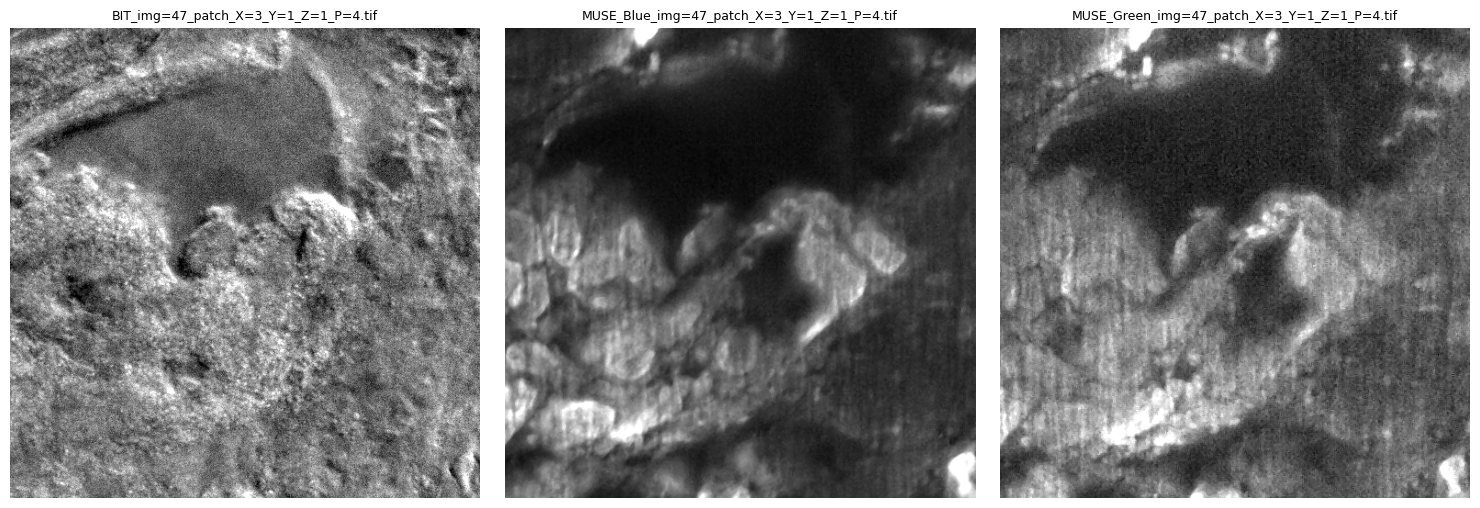

In [8]:
import os
import re
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# Define root folders
root_location = r'/home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/test'
root_bit = os.path.join(root_location, 'normalized_BIT_test')
root_muse_blue = os.path.join(root_location, 'normalized_MUSE_Blue_test')
root_muse_green = os.path.join(root_location, 'normalized_MUSE_Green_test')

# Select BIT image index
bit_idx = random.randint(0, len(os.listdir(root_bit)) - 1)

def extract_xyzp(filename):
    match = re.search(r'_X=(\d+)_Y=(\d+)_Z=(\d+)_P=(\d+)', filename)
    if match:
        return tuple(map(int, match.groups()))
    return None

def find_matching_file(folder, xyzp):
    for fname in os.listdir(folder):
        if extract_xyzp(fname) == xyzp:
            return os.path.join(folder, fname)
    raise FileNotFoundError(f"No file in {folder} with XYZP={xyzp}")

def load_and_prepare_image(path):
    img = tifffile.imread(path)
    if img.ndim > 2:
        img = img[0]  # Take first slice if 3D
    if np.issubdtype(img.dtype, np.floating):
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

# Get filename of selected BIT image
bit_files = sorted(os.listdir(root_bit))  # Ensure consistent order
bit_filename = bit_files[bit_idx]
target_xyzp = extract_xyzp(bit_filename)

if not target_xyzp:
    raise ValueError(f"Failed to extract XYZP from: {bit_filename}")

print(f"Using BIT image: {bit_filename} with XYZP = {target_xyzp}")

# Get full paths to matched files
bit_path = os.path.join(root_bit, bit_filename)
blue_path = find_matching_file(root_muse_blue, target_xyzp)
green_path = find_matching_file(root_muse_green, target_xyzp)

# Load and normalize images
images = [load_and_prepare_image(p) for p in [bit_path, blue_path, green_path]]
titles = [os.path.basename(p) for p in [bit_path, blue_path, green_path]]

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Reconstruct Test Images from Patches so we can reconstruct it later. 

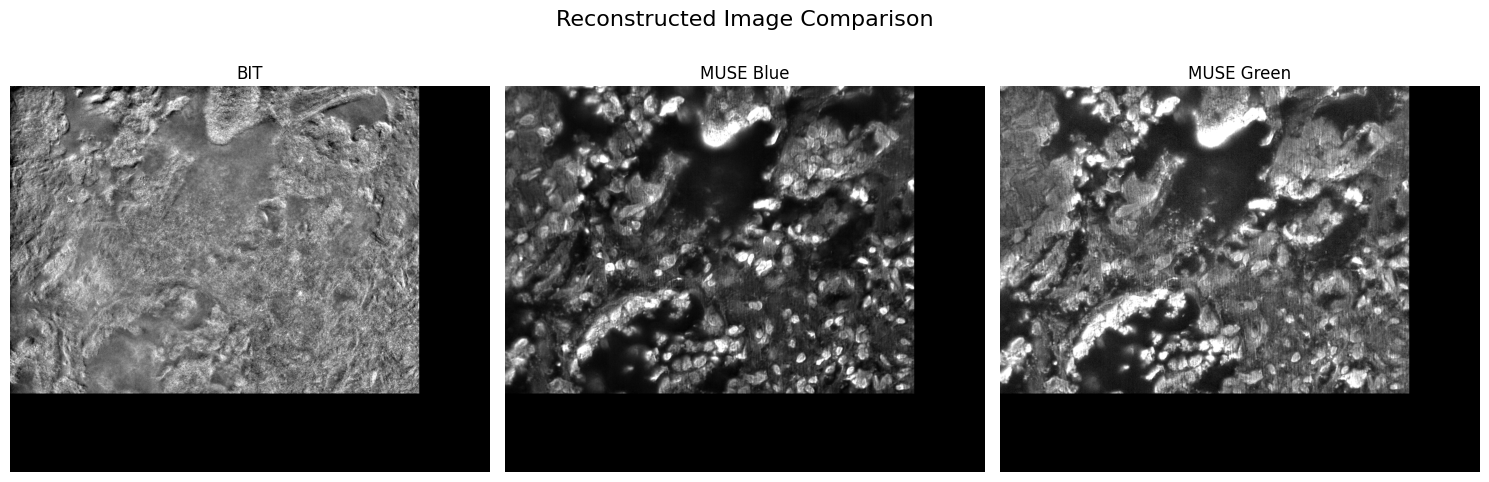

In [ ]:
i = 1

BIT_metadata = get_txt_files_sorted_by_xyz(os.path.join(output_path_test, 'BIT_patches'))
MUSE_Blue_metadata = get_txt_files_sorted_by_xyz(os.path.join(output_path_test, 'MUSE_Blue_patches'))
MUSE_Green_metadata = get_txt_files_sorted_by_xyz(os.path.join(output_path_test, 'MUSE_Green_patches'))


reconstructed_BIT_img = reconstruct_image_from_patches(BIT_metadata[i], os.path.join(output_path_test, 'normalized_BIT_test'))
reconstructed_MUSE_Blue_img = reconstruct_image_from_patches(MUSE_Blue_metadata[i], os.path.join(output_path_test, 'normalized_MUSE_Blue_test'))
reconstructed_MUSE_Green_img = reconstruct_image_from_patches(MUSE_Green_metadata[i], os.path.join(output_path_test, 'normalized_MUSE_Green_test'))


show_three_images(reconstructed_BIT_img, reconstructed_MUSE_Blue_img, reconstructed_MUSE_Green_img,
                subtitles=["BIT", "MUSE Blue", "MUSE Green"],
                main_title="Reconstructed Image Comparison")



### Save Inverted Images 

In [23]:
invert_uint8_images(os.path.join(output_path_test, 'normalized_BIT_test'), os.path.join(output_path_test, 'inverted_normalized_BIT_test'))
invert_uint8_images(os.path.join(output_path_train, 'normalized_BIT_train'), os.path.join(output_path_test, 'inverted_normalized_BIT_train'))



Found 3120 matching pairs.


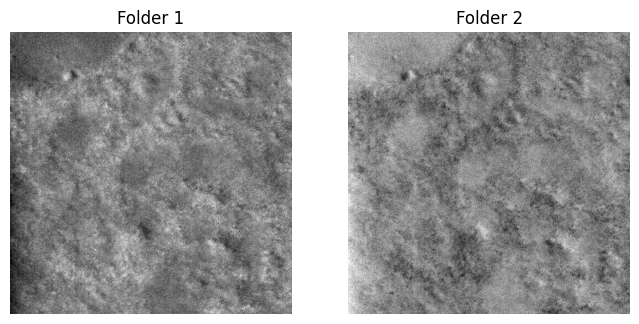

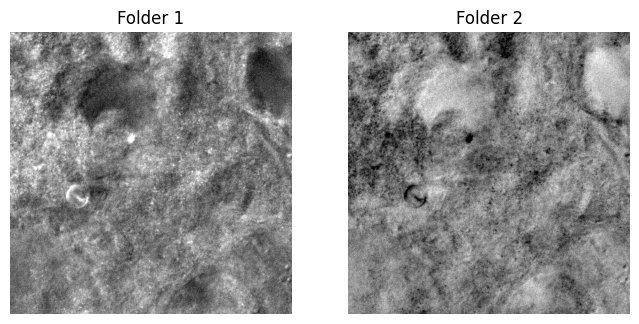

In [ ]:


pairs = get_matching_pairs(os.path.join(output_path_train, 'normalized_BIT_train'), os.path.join(output_path_test, 'inverted_normalized_BIT_train'))
print(f"Found {len(pairs)} matching pairs.")
show_random_pairs(pairs, n=2)

In [43]:
# Example usage:
folders = [
    "/home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/test/normalized_BIT_test",
    "/home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/test/normalized_MUSE_Blue_test",
    "/home/durrlab/Desktop/Anthony/data/20251009_Kidney_MUSE-BIT_KidneyNormal1Accepted/MUSE_BIT/cropped_KidneyNormal1Accepted/patches_KidneyNormal1Accepted/test/normalized_MUSE_Green_test"
]

matched_image_paths = get_matching_image_paths(folders)


### Combine Normal and Inverted Images: ch1: original img, ch2: inverted img, ch3: inverted img

In [ ]:



def get_matching_pairs(folder1, folder2):
    # Build dict of {key: path} for folder1
    dict1 = {extract_key(f): os.path.join(folder1, f) 
             for f in os.listdir(folder1) if extract_key(f)}
    # Build dict of {key: path} for folder2
    dict2 = {extract_key(f): os.path.join(folder2, f) 
             for f in os.listdir(folder2) if extract_key(f)}
    # Find keys present in both
    common_keys = list(set(dict1.keys()) & set(dict2.keys()))
    # Return list of tuples (file1, file2)
    return [(dict1[k], dict2[k]) for k in common_keys]

In [9]:
BIT_test = os.path.join(output_path_test, 'normalized_BIT_test')
inv_BIT_test = os.path.join(output_path_test, 'inverted_normalized_BIT_test')

BIT_train = os.path.join(output_path_train, 'normalized_BIT_train')
inv_BIT_train = os.path.join(output_path_train, 'inverted_normalized_BIT_train')


BIT_matched_image_paths_test = get_matching_image_paths([BIT_test, inv_BIT_test])
BIT_matched_image_paths_train = get_matching_image_paths([BIT_train, inv_BIT_train])

print(len(BIT_matched_image_paths_test))
print(len(BIT_matched_image_paths_train))

24
3120


In [13]:
def combine_image_pairs(image_pairs, output_folder):
    """
    Combines image pairs into 3-channel images:
      - First image -> channel 0
      - Second image -> channels 1 & 2
    Saves each combined image in the output folder with the first image's basename.
    
    Args:
        image_pairs (list of tuples): [(path_img1, path_img2), ...]
        output_folder (str): path to save combined images
    """
    os.makedirs(output_folder, exist_ok=True)
    
    for img_path1, img_path2 in image_pairs:
        # Read images in grayscale
        img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
        
        if img1 is None or img2 is None:
            print(f"Warning: Could not read {img_path1} or {img_path2}")
            continue
        
        # Stack channels
        combined_img = cv2.merge([img1, img2, img1])
        
        # Save using the first image's basename
        basename = os.path.basename(img_path1)
        save_path = os.path.join(output_folder, basename)
        cv2.imwrite(save_path, combined_img)


In [14]:
combine_image_pairs(BIT_matched_image_paths_test,  os.path.join(output_path_test, 'combined_inverted_normalized_BIT_test'))
combine_image_pairs(BIT_matched_image_paths_train,  os.path.join(output_path_train, 'combined_inverted_normalized_BIT_train'))